# Creating tools

## Is It Worth Automating? A Time-Saving Tradeoff Simulation

### Goal

This notebook helps evaluate **when it’s worth building a tool** to automate a repetitive task.

We compare:

- The **cumulative time cost** of doing a task manually (many times per year)
- Against the **one-time development cost** (in days) of building a tool to automate it

We introduce a threshold:  
👉 _A tool is considered worth building if it recovers at least X% of its development time in one year._

This lets us answer questions like:

- _“If I do a 10-minute task 500 times a year, is it worth spending 3 days to automate it?”_
- _“At what point does a 1-minute savings add up enough to justify tool development?”_

### Simulation Parameters

| Parameter             | Description                                                           |
| --------------------- | --------------------------------------------------------------------- |
| `frequency_per_year`  | How often the task is done per year (log scale: 1 to 10,000)          |
| `time_per_task_min`   | Time each task takes manually (log scale: 0.1 to 100 minutes)         |
| `dev_time_days`       | Time needed to build the automation tool (log scale: 0.1 to 100 days) |
| `justification_ratio` | Threshold to consider the tool worth it (e.g., 50%)                   |

### Outputs

- A **log-scaled heatmap** showing when tool building is justified based on:
  - Frequency of the task
  - Manual task duration
  - Fixed dev time
- A **decision table** showing scenarios where automation is worth it


Using dev_time_days = 4.942


AttributeError: module 'matplotlib.pyplot' has no attribute 'tight_lawet'

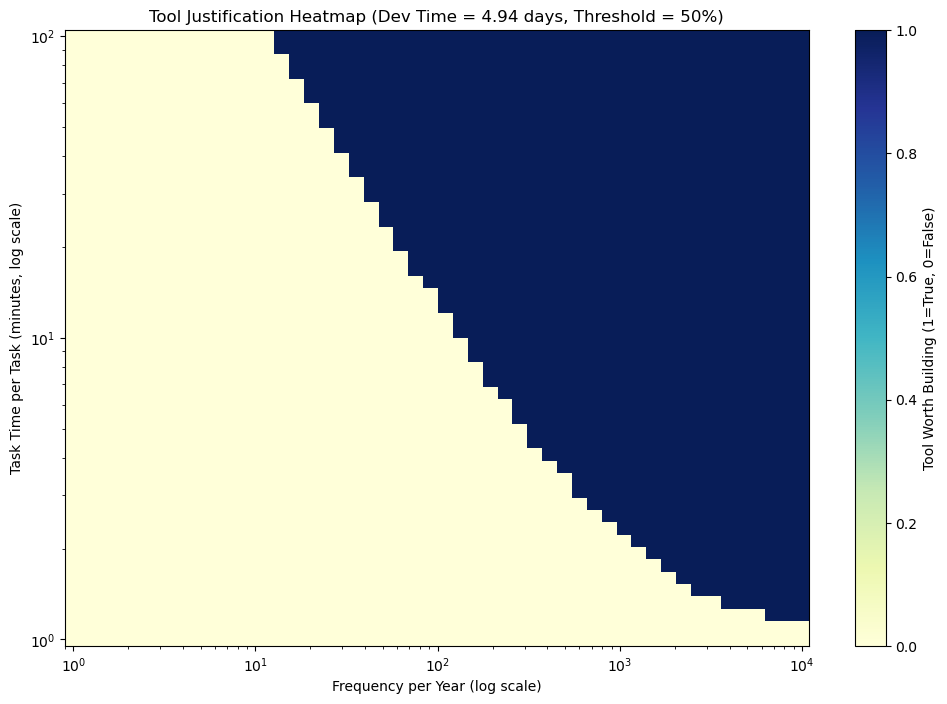

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
frequencies = np.logspace(0, 4, num=50)  # 1 to 10,000 times per year
times_per_task = np.logspace(0, 2, num=50)  # 1 to 100 minutes
dev_times_days = np.logspace(0, 2, num=50)  # 1 to 100 days
justification_ratio = (
    0.5  # 50% of time recovered is enough to justify the devlopment effort
)

# Find closest to 5
target_dev_time = 5

# Fixed conversion
minutes_per_day = 60 * 8  # Assuming 8-hour workdays

closest_value = dev_times_days[np.abs(dev_times_days - target_dev_time).argmin()]
print(f"Using dev_time_days = {closest_value:.3f}")


# Create simulation results
results = []
for freq in frequencies:
    for task_time in times_per_task:
        for dev_days in dev_times_days:
            yearly_manual_time = freq * task_time  # in minutes
            yearly_automated_time = freq * 1  # reduced to 1 minute per task
            time_saved_yearly = yearly_manual_time - yearly_automated_time

            dev_time_minutes = dev_days * minutes_per_day

            is_worth_it = time_saved_yearly >= (justification_ratio * dev_time_minutes)

            results.append(
                {
                    "frequency": freq,
                    "task_time_min": task_time,
                    "dev_time_days": dev_days,
                    "dev_time_min": dev_time_minutes,
                    "time_saved": time_saved_yearly,
                    "worth_it": is_worth_it,
                }
            )

# Convert to DataFrame
df = pd.DataFrame(results)

# Let's fix dev_time_days for the heatmap slice
dev_time_slice = 5  # e.g., fix at 5 days of dev
tolerance = 1e-3
df_slice = df[np.isclose(df["dev_time_days"], closest_value, atol=tolerance)]

# Sanity check
if df_slice.empty:
    raise ValueError(
        f"No data found for dev_time_days ≈ {dev_time_slice} and closest_value ≈ {closest_value}"
    )

# Get unique x and y values from wer filtered slice
x = np.sort(df_slice["frequency"].unique())
y = np.sort(df_slice["task_time_min"].unique())

# Prepare 2D array of "worth_it" values
z = (
    df_slice.pivot_table(
        index="task_time_min", columns="frequency", values="worth_it", aggfunc="first"
    )
    .reindex(index=y, columns=x)
    .fillna(False)
    .astype(float)
    .values
)

# Create plot
plt.figure(figsize=(12, 8))
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, z, shading="auto", cmap="YlGnBu")

# Set log scale
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Frequency per Year (log scale)")
plt.ylabel("Task Time per Task (minutes, log scale)")
plt.title(
    f"Tool Justification Heatmap (Dev Time = {closest_value:.2f} days, Threshold = {justification_ratio*100:.0f}%)"
)

# Colorbar
cbar = plt.colorbar()
cbar.set_label("Tool Worth Building (1=True, 0=False)")

plt.tight_layout()
plt.show()

## Interpretation of the Tool Justification Heatmap

### Axes

- **X-axis (horizontal):**  
  `Frequency per Year` on a **log scale**  
  → How often the task is done annually (from 1 to 10,000 times)

- **Y-axis (vertical):**  
  `Task Time per Task` in **minutes**, also log scale  
  → How long each manual execution takes (from ~1 minute to 100 minutes)

### **Color Scale**

- **Dark Blue (1):** Tool is **worth building**
- **Light Yellow (0):** Tool is **not worth it**
- We have used a **threshold of 50%** — so a tool is only "worth it" if it saves **at least half** of its development time (in minutes) **within one year**.

### Key Insights

- **There’s a clear decision boundary**
  We can see a **diagonal transition** from yellow to blue.  
  This means the tool becomes "worth it" once the **product of frequency × task time** exceeds a certain threshold.

That makes sense — even small tasks (e.g., 1 minute) can justify automation if they’re repeated **often enough**.

- **Higher frequency can compensate for small task time**
  For example:
- A task that takes only **2 minutes**, if done **5,000+ times a year**, is well worth automating.
- Conversely, a **20-minute task** only done once or twice a year doesn’t justify a 5-day dev investment.

- **Time saved grows linearly; log scale shows exponential tipping points**
  Because we're using a **log-log scale**, the transition area represents an **order-of-magnitude shift**:
- Going from 10 to 100 tasks/year,
- Or from 1 to 10 minutes/task,
- Can **drastically** change whether the tool is worth building.

- **“Automation is worth it sooner than we think”**
  Even tasks that take **~5 minutes**, if done **a few hundred times**, can justify a 5-day build — especially under a 50% savings threshold.

### Rule of Thumb We Can Derive

> _"If a task is done more than 100× a year, and takes more than 10 minutes, it’s almost always worth automating."_  
> _(Under a 5-day dev time and 50% recovery threshold)_


In [ ]:
import pandas as pd
import numpy as np

# Define dev time values you're interested in
dev_times_to_check = [0.1, 0.5, 1, 2, 5, 10, 20, 50]

# Prepare output
threshold_rows = []

for dev_time in dev_times_to_check:
    # Find closest available value in simulation
    closest_value = dev_times_days[np.abs(dev_times_days - dev_time).argmin()]
    
    # Filter for that dev time
    df_dev = df[np.isclose(df['dev_time_days'], closest_value, atol=1e-3)].copy()
    
    # Only look at rows where the tool is worth it
    worth_it_rows = df_dev[df_dev['worth_it']].copy()
    
    # Calculate threshold value = frequency × task time
    if not worth_it_rows.empty:
        worth_it_rows["threshold_product"] = worth_it_rows["frequency"] * worth_it_rows["task_time_min"]
        min_threshold = worth_it_rows["threshold_product"].min()
    else:
        min_threshold = np.nan  # no situation where tool is worth it
    
    threshold_rows.append({
        "Dev Time (days)": round(closest_value, 2),
        "Min (Frequency × Task Time)": round(min_threshold, 2) if not np.isnan(min_threshold) else "N/A"
    })

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_rows)
threshold_df


,Dev Time (days),Min (Frequency × Task Time)
0,1.00,255.95
1,1.00,255.95
2,1.00,255.95
3,1.93,494.17
4,4.94,1264.86
5,9.54,2442.05
6,20.24,5179.47
7,51.79,13257.11
